In [1]:
import numpy as np
from scipy.integrate import quad, odeint, solve_ivp
from scipy.special import kn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

import pickle

import math
from numpy import cos, sin, pi

import lib.config as config

from importlib import reload

import lib.utils
import lib.Xsecs
import lib.cosmo_def

#%matplotlib inline
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
plt.rcParams['text.usetex'] = True

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [2]:
mNval = 10

time = np.logspace(np.log10(8e-3),np.log10(5e10), 600)


MeV_to_invsec = config.MeV_to_invsec

##############################
### Assign input variables ###
##############################

config.config_params['Lnu'] = 1e-1
config.config_params['Lchi'] = 3e-3
config.config_params['chi_flav'] = 1

config.config_params['m_nl1'] = 3e-8
config.config_params['m_nl2'] = 3e-8
config.config_params['m_nl3'] = 3e-8

config.config_params['mN1'] = mNval
config.config_params['mN2'] = mNval
config.config_params['mN3'] = mNval

config.config_params['Mass_phi'] = 1
config.config_params['Mass_chi'] = 1e-9


Lnu = config.config_params['Lnu']
Lchi = config.config_params['Lchi']

m_nl1 = config.config_params['m_nl1']
m_nl2 = config.config_params['m_nl2']
m_nl3 = config.config_params['m_nl3']

mN1 = config.config_params['mN1']
mN2 = config.config_params['mN2']
mN3 = config.config_params['mN3']

Mass_phi = config.config_params['Mass_phi']
Mass_chi = config.config_params['Mass_chi']

chi_flav = config.config_params['chi_flav']


reload(lib.utils)
reload(lib.Xsecs)
reload(lib.cosmo_def)

from lib.utils import *
from lib.Xsecs import *
from lib.cosmo_def import *

# Decay width of phi
phi_decayW = decayWidth_phi(chi_flav, Lchi, Mass_phi)

# G_eff of chi SI
Geffchi = Geffchi(Lchi, Mass_phi)

# Neff Definition
def Neff_nu(Ty, Tnu_e, Tnu_mu):
    return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu))/rho_y(Ty)

def Neff(Ty, Tnu_e, Tnu_mu, Tchi):
    return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu) + rho_chi(Tchi, chi_flav))/rho_y(Ty)

In [9]:
# Interaction Rate calculation
def Gamma_T_enlenl(Temp):
    
    intval = 0
    stepsize = 0.1
    initG = np.log10(0.512**2).round()
    finG = 10
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         ( 5.57e-24*s + 1/s*2.85e-25 - 3.485e-24 )*s*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    
    prefactor = 1/(8*Temp**5)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real

def Gamma_T_enlenh(Temp):
    
    intval = 0
    stepsize = 0.1
    initG = np.log10(10**2).round()
    finG = 10
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         sqrt(s-100)/sqrt(s)*( 1.672e-32*s + 1/s*3.283e-31 - 6.375e-31 )*s*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    
    prefactor = 1/(8*Temp**5)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real

def Gamma_T_nlnlnlnh(Temp):
    
    intval = 0
    stepsize = 0.1
    initG = np.log10(10**2).round()
    finG = 10
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         sqrt(s-100)/sqrt(s)*( 8.89434e-32*s - 1/s*1.51434e-29 - 7.11547e-30)*s*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
        
    prefactor = 1/(8*Temp**5)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real

def Gamma_T_nlnlnhnh(Temp):
    
    intval = 0
    stepsize = 0.1
    initG = np.log10(20**2).round()
    finG = 10
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         sqrt(s-400)/sqrt(s)*( 1e-22/s )*s*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    
    prefactor = 1/(8*10**4*Temp*(kn(2, 10/Temp))**2)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real


In [10]:
T_bath = np.logspace(-1,4,100)

Gam_enlenl_over_H = []
Gam_enlenh_over_H = []
Gam_2nlnlnh_over_H = []
Gam_2nl2nh_over_H = []

for ii in range(len(T_bath)):
    interaction_rate = MeV_to_invsec*Gamma_T_enlenl(T_bath[ii])
    interaction_rate2 = MeV_to_invsec*Gamma_T_enlenh(T_bath[ii])
    interaction_rate3 = MeV_to_invsec*Gamma_T_nlnlnlnh(T_bath[ii])
    interaction_rate4 = MeV_to_invsec*Gamma_T_nlnlnhnh(T_bath[ii])
    
    hubble = Hubble(T_bath[ii], T_bath[ii], T_bath[ii], 1e-5, 1, 0.01)
    
    Gam_enlenl_over_H.append(interaction_rate/hubble)
    Gam_enlenh_over_H.append(interaction_rate2/hubble)
    Gam_2nlnlnh_over_H.append(interaction_rate3/hubble)
    Gam_2nl2nh_over_H.append(interaction_rate4/hubble)
    
    #if (ii+1)%10==0:
    #    print(ii)

Gam_enlenl_over_H = np.array(Gam_enlenl_over_H)
Gam_enlenh_over_H = np.array(Gam_enlenh_over_H)
Gam_2nlnlnh_over_H = np.array(Gam_2nlnlnh_over_H)
Gam_2nl2nh_over_H = np.array(Gam_2nl2nh_over_H)

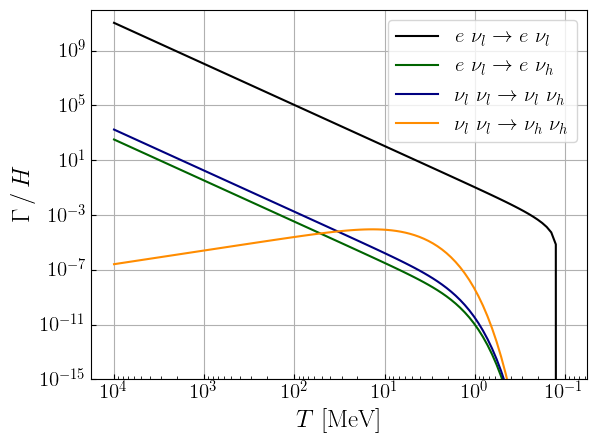

In [13]:
plt.plot(T_bath, Gam_enlenl_over_H, 'black',label=r'$e ~\nu_l\to e~\nu_l$')
plt.plot(T_bath, Gam_enlenh_over_H, 'darkgreen',label=r'$e~ \nu_l\to e~\nu_h$')
plt.plot(T_bath, Gam_2nlnlnh_over_H, 'navy',label=r'$\nu_l~\nu_l\to\nu_l~\nu_h$')
plt.plot(T_bath, Gam_2nl2nh_over_H, 'darkorange',label=r'$\nu_l~\nu_l\to\nu_h~\nu_h$')


plt.gca().invert_xaxis()

plt.xscale('log')
plt.yscale('log')
plt.legend( fontsize=15)
plt.ylim(1e-15,1e12)
plt.ylabel(r'$\Gamma \, /\, H$',fontsize=18)
plt.xlabel(r'$T$ [MeV]',fontsize=18)
plt.tick_params(axis='both', direction="in", which="both", labelsize=15)

plt.grid()

plt.savefig(f"./Rate_to_Hubble_HNL_production.pdf",
            bbox_inches = 'tight')
plt.show()